In [82]:
#get 10 files, each is the same timestep for a member of a
#10 member ensemble
import numpy as np
import urllib.request
data_download=False
if data_download:
    root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles'
    for i in np.arange(1,11,dtype=np.int):
        the_name='mar12014_{:d}_15600.nc'.format(i)
        print(the_name)
        url='{}/{}'.format(root,the_name)
        urllib.request.urlretrieve(url,the_name)
           

Useful links:

We need:

* [namedtuples](https://docs.python.org/3/library/collections.html#collections.namedtuple)

* [numpy.savez](http://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html)

* [vapor](https://www.vapor.ucar.edu/)

* [vapor videos](https://www.youtube.com/channel/UCVSuoneyeZFn4Znxl_jJ70A)

* [xray and dask](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python)

## First load a couple of utility functions

In [83]:
import glob
import xray
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple
import textwrap

def sort_name(name):
    """
      sort the filenames so '10' sorts
      last by converting to integers
    """
    front, number, back = name.split('_')
    return int(number)


def dict_to_nt(the_dict, tupname):
    """
      convert a dictionary into a namedtuple
    """
    # first define the keys as attributes
    In_tup = namedtuple(tupname, the_dict.keys())
    # then read the key,value pairs in and assign to
    # attributes
    out_tuple = In_tup(**the_dict)
    return out_tuple


Now use xray to stitch together the 10 ensemble members along a new "virtual dimenstion".
The variable "ds"  is an xray dataset, which controls the reads/writes from the
10 netcdf files


In [84]:
the_files = glob.glob('mar*nc')
the_files.sort(key=sort_name)

#
#  put the 10 ensembles together along a new "ens" dimension
#  using an xray multi-file dataset
#
#  Checkpointing
#
#  This is slow, so only do it once, and store the variables
#  using np.savez.   Then set firstrun=False and read the 
#  variables out of the npz file instead of recalculating
#
#  Store the variables in a namedtuple so we don't have to continually
#  be typing in dictionary indices  (too many keystrokes)
#
#
firstrun = False
if firstrun:
    ds = xray.open_mfdataset(the_files, engine='netcdf4', concat_dim='ens')
    # dump the structure
    print(ds)
    #
    #  3-d ensemble average for temp
    #
    x = ds['x']
    y = ds['y']
    z = ds['z']
    temp = ds['TABS']
    pres = ds['p']
    Rd = 287  # dry air gas constant  J/kg/K
    cp = 1004.  # dry air heat capacity at constant pressure (J/kg/K)
    p0 = 1.e5  # reference pressure (Pa)
    theta = temp * (p0 / pres )**(Rd/cp)
    mean_temp = temp[:, 0, :, :, :].mean(dim='ens')
    mean_theta = theta[:, 0, :, :, :].mean(dim='ens')
    #
    # same for velocity
    #
    wvel = ds['W']
    mean_w = wvel[:, 0, :, :, :].mean(dim='ens')
    #
    # now look at the perturbation fields for one ensemble
    #
    wvelprime = wvel[0, 0, :, :, :] - mean_w
    Tprime = temp[0, 0, :, :, :] - mean_temp
    theta_prime2 = (theta[0, 0, :, :, :] - mean_theta)**2
    flux_prime = wvelprime * Tprime
    flux_profile = flux_prime.mean(dim='x').mean(dim='y')
    theta_profile2 = theta_prime2.mean(dim='x').mean(dim='y')
    keep_dict = dict(flux_prof=flux_profile, flux_prime=flux_prime.values,wvelprime=wvelprime.values,
                     Tprime=Tprime.values, theta_p2 = theta_prime2, x=x, y=y, z=z,theta_pro2 = theta_profile2)
    np.savez('dump.npz', **keep_dict)
    var_tup = dict_to_nt(keep_dict, 'vars')
    print(var_tup._fields)
else:
    in_dict = np.load('dump.npz')
    var_tup = dict_to_nt(in_dict, 'vars')
    print(var_tup._fields)


('wvelprime', 'flux_prof', 'Tprime', 'y', 'theta_pro2', 'theta_p2', 'z', 'flux_prime', 'x')


## Plotting theta'^2 

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


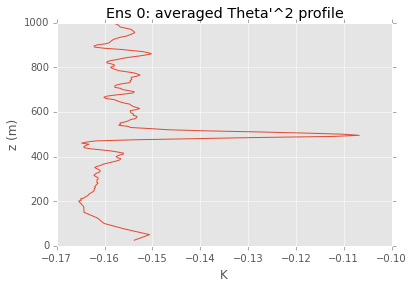

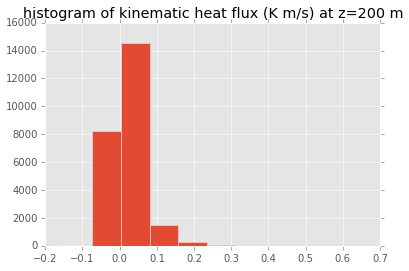

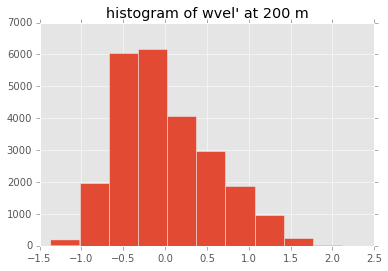

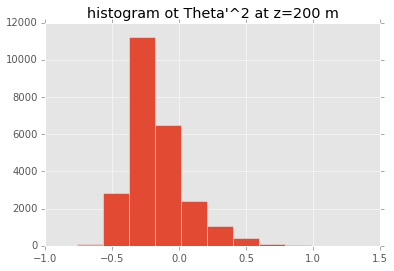

In [85]:
%matplotlib inline
plt.style.use('ggplot')
fig1, ax1 = plt.subplots(1, 1)
ax1.plot(var_tup.theta_pro2, var_tup.z)
ax1.set(ylim=[0, 1000], title="Ens 0: averaged Theta'^2 profile",
        ylabel='z (m)', xlabel='K')

fig2, ax2 = plt.subplots(1, 1)
z200 = np.searchsorted(var_tup.z, 200)
ax2.hist(var_tup.flux_prime[z200, :, :].flat)
ax2.set(title='histogram of kinematic heat flux (K m/s) at z=200 m')

fig3, ax3 = plt.subplots(1, 1)
ax3.hist(var_tup.wvelprime[z200, :, :].flat)
ax3.set(title="histogram of wvel' at 200 m")

print (type(var_tup.wvelprime),type(var_tup.theta_p2))

fig4, ax4 = plt.subplots(1, 1)
ax4.hist(var_tup.theta_p2[z200, :, :].flat)
ax4.set(title="histogram ot Theta'^2 at z=200 m")



# Conditional sampling the flux

Write 100 where there is postively buoyant ascending air and 1 everywhere else"

In [86]:
hit = np.logical_and(var_tup.wvelprime > 0, var_tup.Tprime > 0)

pos_buoyant = np.ones_like(var_tup.flux_prime, dtype=np.float32)
#pos_buoyant[hit] = var_tup.flux_prime[hit]
pos_buoyant[hit] = pos_buoyant[hit]*100.

# Creating the Block

In [87]:
block = np.zeros_like(var_tup.theta_p2, dtype=np.float32)
block[56:257,24:105,41:142] = 1

# writing a vapor vdf file

First we need to output the x, y and z coordinates in separate files

In [88]:
filenames = ['xvals.txt', 'yvals.txt', 'zvals.txt']
arrays = [var_tup.x, var_tup.y, var_tup.z]
for name, vals in zip(filenames, arrays):
    print (type(vals))
    with open(name, 'w') as outfile:
        #
        # write all but the last without a newline
        #
        [outfile.write('{:6.3f} '.format(item)) for item in vals[:-1]]
        #
        # write the last value with a newline
        #
        outfile.write('{:6.3f}\n'.format(vals[-1]))
    

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Writing bouancy, theta'^2 and, the arbitrary column

In [93]:
varname1 = 'buoyancy'
varname2 = "Theta"
varname3 = 'column'

out_name = '{}.bin'.format(varname1)
rev_shape = pos_buoyant.shape[::-1]
string_shape="{}x{}x{}".format(*rev_shape)
print('writing an array of {} of shape x,y,z= {}'.format(varname1,string_shape))
fp = np.memmap(out_name, dtype=np.float32,
               mode='w+', shape=pos_buoyant.shape)
fp[...] = pos_buoyant[...]


out_name = '{}.bin'.format(varname2)
rev_shape = var_tup.theta_p2.shape[::-1]
string_shape="{}x{}x{}".format(*rev_shape)
print('writing an array of {} of shape x,y,z= {}'.format(varname2,string_shape))
fp = np.memmap(out_name, dtype=np.float32,
               mode='w+', shape=var_tup.theta_p2.shape)
fp[...] = var_tup.theta_p2[...]

out_name = '{}.bin'.format(varname3)
rev_shape = block.shape[::-1]
string_shape="{}x{}x{}".format(*rev_shape)
print('writing an array of {} of shape x,y,z= {}'.format(varname3,string_shape))
fp = np.memmap(out_name, dtype=np.float32,
               mode='w+', shape=block.shape)
fp[...] = block[...]



writing an array of buoyancy of shape x,y,z= 192x128x312
writing an array of Theta of shape x,y,z= 192x128x312
writing an array of column of shape x,y,z= 192x128x312


# Tried to write one raw2vdf command that did all three variables, but couldn't get it to work so i just did it the long way

In [96]:
 vars=dict(dim=string_shape,var1='buoyancy',var2='Theta',var3='column',name='Three_vars')
    
command=r"""
    vdfcreate  -xcoords xvals.txt -ycoords yvals.txt -zcoords zvals.txt \
       -gridtype stretched -dimension {dim:s} -vars3d {var1:s}:{var2:s}:{var3:s} -numts 1 {name:s}.vdf  

    raw2vdf -varname {var1:s} -ts 0 {name:s}.vdf {var1:s}.bin 
    raw2vdf -varname {var2:s} -ts 0 {name:s}.vdf {var2:s}.bin
    raw2vdf -varname {var3:s} -ts 0 {name:s}.vdf {var3:s}.bin
"""
out=textwrap.dedent(command.format_map(vars))
with open('make_vapor.sh','w') as f:
    f.write('#!/bin/bash -v\n')
    f.write(out)

In [97]:
!cat nu_make_vapor.sh

#!/bin/bash -v

vdfcreate  -xcoords xvals.txt -ycoords yvals.txt -zcoords zvals.txt \
   -gridtype stretched -dimension 192x128x312 -vars3d buoyancy:Theta -numts 1 Three_vars.vdf  

raw2vdf -varname buoyancy -ts 0 Three_vars.vdf buoyancy.bin 
raw2vdf -varname Theta -ts 0 Three_vars.vdf Theta.bin


Now open a terminal (osx) or a bash-shell (windows) and setup the path for vapor
following these [osx instructions](https://www.vapor.ucar.edu/docs/vapor-installation/vapor-mac-binary-installation) or these
[windows instructions]( https://www.vapor.ucar.edu/docs/vapor-installation/vapor-windows-binary-installation)

Once you've done this, vdfcreate and raw2vdf should be in our path, and
you should  be able to do:

```bash
> bash make_vapor.sh
```

If this works, there should be a new file called

  buoyancy.vdf
  
and a new folder called

  buoyancy_data
  
Now executate

  vaporgui
  
from the same terminal